### Saliency map

https://raghakot.github.io/keras-vis/visualizations/saliency/

Categorical Dense layer visualization - contribute most towards activating the corresponding output nodes

Conv filter saliency - visualize parts of the image that influence the filter

In [182]:
import numpy as np
import time 
import matplotlib.pyplot as plt
%matplotlib inline 

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import activations
from keras import backend as K
# from keras.preprocessing.image import save_img
from scipy.misc import imsave
import imageio

from vis.visualization import visualize_saliency
from vis.utils import utils



In [2]:
# model configuration 

NUM_CLASSES = 2
IMG_WI = 224
IMG_HI = 224


In [4]:
# load processed data for training 

hello = np.load('processed_hello.npy')
no_hello = np.load('processed_no_hello.npy')


In [5]:

def cnn_model():
    model = Sequential()
    
    # zero padding
    model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (IMG_WI, IMG_HI, 3), activation = 'relu'))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation = 'softmax', name = 'preds'))
    
    return model


In [238]:
# load the model

model = cnn_model()
model.load_weights('./saved_models/model_high_dropout.h5')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 54, 54, 64)        0         
__________

#### Categorical Dense layer visualization

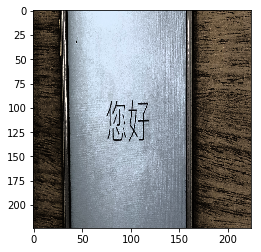

In [68]:
# pick a random picture from all processed hello pictures 

idx = 3
plt.imshow(hello[idx])


/Users/yueying.teng/miniconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


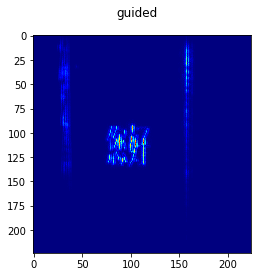

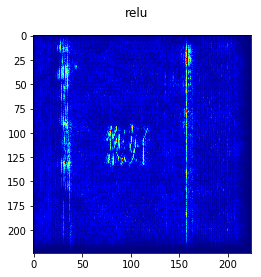

In [83]:

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

class_idx = [1, 0]

for modifier in ['guided', 'relu']:
    plt.figure()
    plt.suptitle(modifier)

    grads = visualize_saliency(model, layer_idx, filter_indices = class_idx, 
                               seed_input =  hello[idx], backprop_modifier = modifier)
    # overlay the heatmap onto original image.    
    plt.imshow(grads, cmap = 'jet')

        
# # set filter_indices for the desired output category
# class_idx = [1, 0]
# grads = visualize_saliency(model, layer_idx, filter_indices = class_idx, backprop_modifier = 'relu', seed_input = hello[idx])
# # Plot with 'jet' colormap to visualize as a heatmap.
# plt.imshow(grads, cmap='jet')


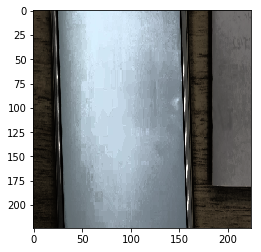

In [12]:
# for pictures without hello 
# original picture 
plt.imshow(no_hello[idx])


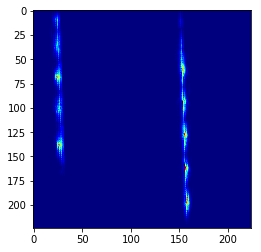

In [88]:

class_idx = [0, 1]
grads = visualize_saliency(model, layer_idx, filter_indices = class_idx, backprop_modifier = 'guided', seed_input = no_hello[idx])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')



#### Conv filter saliency

By pointing layer_idx to Conv layer, you can visualize parts of the image that influence the filter. This might help you discover what a filter cares about.

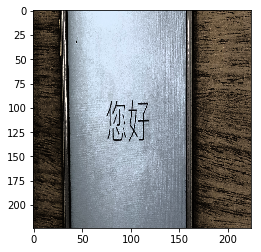

In [85]:
idx = 3

plt.imshow(hello[idx])

<Figure size 432x288 with 0 Axes>

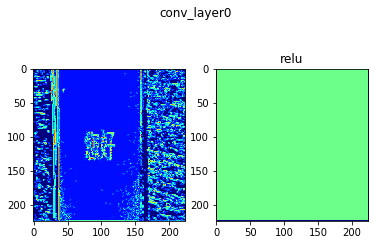

<Figure size 432x288 with 0 Axes>

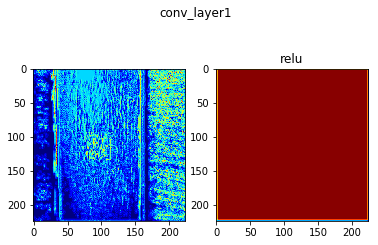

<Figure size 432x288 with 0 Axes>

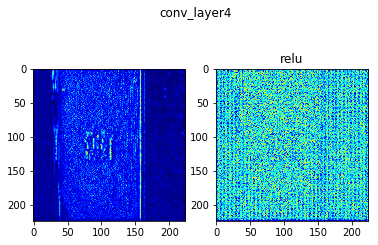

<Figure size 432x288 with 0 Axes>

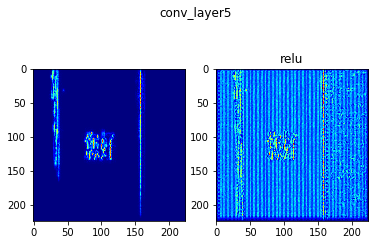

<Figure size 432x288 with 0 Axes>

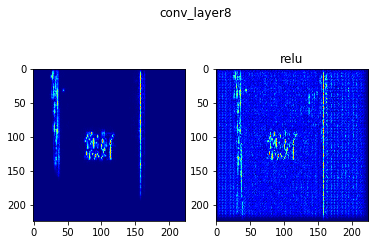

<Figure size 432x288 with 0 Axes>

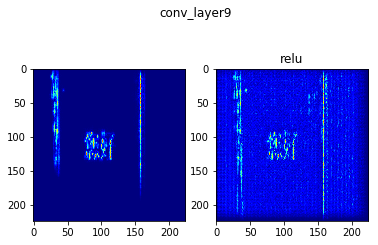

In [109]:
# plot filter saliency of all conv layer 

layers = model.layers 
# get all conv layer indices
all_conv_index = [index for index, layer in enumerate(layers) if type(layer) is Conv2D]

# filter_indices refers to the index of the Conv filter within the layer 
class_idx = [1, 0]

# point layer_idx to Conv layer - what a filter cares about - index of the second last conv layer 


# compare two modifiers on saliency map

for i in all_conv_index:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle('conv_layer' + str(i))

    for j, modifier in enumerate(['guided', 'relu']):

        layer_idx = i
        # saliency of current conv layer filter 
        grads = visualize_saliency(model, layer_idx, filter_indices = class_idx, backprop_modifier = modifier, seed_input = hello[idx])

        # Plot with 'jet' colormap to visualize as a heatmap.

        ax[j].imshow(grads, cmap = 'jet')
        plt.title(modifier)



guided backpropagation seems to work better in both visualizing Conv layers and the final Dense layer.

### activation maximization

https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [239]:
model.layers.pop()

In [240]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

layer_dict

{'conv2d_25': <keras.layers.convolutional.Conv2D at 0x1d0370e8d0>,
 'conv2d_26': <keras.layers.convolutional.Conv2D at 0x1d0370e080>,
 'max_pooling2d_13': <keras.layers.pooling.MaxPooling2D at 0x1d094be320>,
 'dropout_17': <keras.layers.core.Dropout at 0x1d094f2518>,
 'conv2d_27': <keras.layers.convolutional.Conv2D at 0x1d094f26a0>,
 'conv2d_28': <keras.layers.convolutional.Conv2D at 0x1d0950ac88>,
 'max_pooling2d_14': <keras.layers.pooling.MaxPooling2D at 0x1d0383a518>,
 'dropout_18': <keras.layers.core.Dropout at 0x1d038813c8>,
 'conv2d_29': <keras.layers.convolutional.Conv2D at 0x1d03881fd0>,
 'conv2d_30': <keras.layers.convolutional.Conv2D at 0x1d0389ac88>,
 'max_pooling2d_15': <keras.layers.pooling.MaxPooling2D at 0x1d038ae518>,
 'dropout_19': <keras.layers.core.Dropout at 0x1d038ef860>,
 'flatten_5': <keras.layers.core.Flatten at 0x1d0390b4a8>,
 'dense_5': <keras.layers.core.Dense at 0x1d0390b6a0>,
 'dropout_20': <keras.layers.core.Dropout at 0x1d04b13da0>}

In [241]:
# placeholder for the input images

input_img = model.input
input_img

<tf.Tensor 'conv2d_25_input:0' shape=(?, 224, 224, 3) dtype=float32>

In [248]:
# extract and display the generate input 

# function to convert a tensor to a valid image 
def deprocess_image(x):
    # normalize tensor: center on 0, ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
#     x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x


In [221]:
# img = input_img_data[0]
# img = deprocess_image(img)

# img.shape

(224, 224, 3)

In [249]:

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


In [223]:
# name of the layer to be visualized

layer_name = 'conv2d_19'


kept_filters = []

for filter_index in range(120):
    # only scan through the first 120 filters, but there are actually more of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # build a loss function that maximizes the activation of the nth filter of the layer considered
    # gradient of the mean(filter output) wrt the input; filter output is a matrix
    layer_output = layer_dict[layer_name].output
    
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: normalize the gradient
    grads = normalize(grads)

    # this function(function instantiates by keras) returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1

    # start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, IMG_HI, IMG_WI))
    else:
        input_img_data = np.random.random((1, IMG_HI, IMG_WI, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        # only interested in positive ouput, as we want to synthesize a pic that get the fitler in study activated the most  
        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # zero loss means mean(filter output) is zero. i.e. zero gradient. this won't contribute anything to the maximization wrt input pixels
            # some filters get stuck to 0 or, skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
        
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

    
    
# stich the best 64 filters on a 8 x 8 grid.
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# only keep the top 64 filters.
kept_filters.sort(key = lambda x: x[1], reverse = True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for the 8 x 8 filters of size 224 x 224, with a 5px margin in between
margin = 5
width = n * IMG_WI + (n - 1) * margin
height = n * IMG_HI + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(IMG_WI + margin) * i: (IMG_WI + margin) * i + IMG_WI,
                         (IMG_HI + margin) * j: (IMG_HI + margin) * j + IMG_HI, :] = img     

# save result to disk
imageio.imwrite('stitched_filters_%dx%d.png' % (n, n), stitched_filters)



Processing filter 0
Current loss value: 0.19264388
Current loss value: 0.24848472
Current loss value: 0.30432552
Current loss value: 0.36016628
Current loss value: 0.41602302
Current loss value: 0.47194108
Current loss value: 0.52785915
Current loss value: 0.5837771
Current loss value: 0.6397338
Current loss value: 0.6958035
Current loss value: 0.75187343
Current loss value: 0.80794317
Current loss value: 0.86403424
Current loss value: 0.92022943
Current loss value: 0.976538
Current loss value: 1.033224
Current loss value: 1.0912414
Current loss value: 1.1517683
Current loss value: 1.2157952
Current loss value: 1.2855177
Filter 0 processed in 3s
Processing filter 1
Current loss value: 20.411947
Current loss value: 20.581211
Current loss value: 20.750494
Current loss value: 20.919777
Current loss value: 21.089056
Current loss value: 21.258333
Current loss value: 21.42759
Current loss value: 21.59689
Current loss value: 21.76616
Current loss value: 21.935442
Current loss value: 22.104717

Current loss value: 0.39460856
Current loss value: 0.42059198
Current loss value: 0.44681612
Current loss value: 0.47309586
Current loss value: 0.4999264
Current loss value: 0.5273218
Current loss value: 0.5547817
Filter 13 processed in 3s
Processing filter 14
Current loss value: 38.159054
Current loss value: 38.558285
Current loss value: 38.957535
Current loss value: 39.356743
Current loss value: 39.75599
Current loss value: 40.15527
Current loss value: 40.554493
Current loss value: 40.953754
Current loss value: 41.35306
Current loss value: 41.7523
Current loss value: 42.151558
Current loss value: 42.55088
Current loss value: 42.950115
Current loss value: 43.34938
Current loss value: 43.74872
Current loss value: 44.14797
Current loss value: 44.547222
Current loss value: 44.946587
Current loss value: 45.345863
Current loss value: 45.745136
Filter 14 processed in 3s
Processing filter 15
Current loss value: 0.5982304
Current loss value: 0.97065336
Current loss value: 1.3580759
Current lo

Current loss value: 25.408432
Current loss value: 25.775661
Current loss value: 26.142845
Current loss value: 26.510044
Current loss value: 26.877207
Current loss value: 27.244425
Current loss value: 27.611607
Filter 27 processed in 3s
Processing filter 28
Current loss value: 0.014309461
Current loss value: 0.06720649
Current loss value: 0.12765984
Current loss value: 0.18975848
Current loss value: 0.25337398
Current loss value: 0.3217374
Current loss value: 0.40243724
Current loss value: 0.49892682
Current loss value: 0.61102146
Current loss value: 0.73301816
Current loss value: 0.86313623
Current loss value: 1.0015941
Current loss value: 1.1482695
Current loss value: 1.3016863
Current loss value: 1.4620525
Current loss value: 1.629418
Current loss value: 1.8030533
Current loss value: 1.9842459
Current loss value: 2.1712563
Current loss value: 2.3632703
Filter 28 processed in 3s
Processing filter 29


Current loss value: 0.0
Filter 29 processed in 3s
